<h1> Parameter Tuning 
    
    Look at n_neurons & n_hidden layers

# Importing libraries:

In [51]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt

# months to evaluate model on
date = 2018090000

# for later use
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import data; set X and y; fill nan values and split in test and training  data:

In [52]:
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values in the whole data set
data.fillna(data.mean(), inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [53]:
from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing packages:

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers

# Need to process data with spike occurences the same way as features and offers:
(Required to evaluate predictions in both normal regions and spike regions)

In [55]:
steps = 96 
batch_size = 96

# download data for shaded area
data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# make sure shaded area will correspond to values outputed by LSTM
data.reset_index(drop = True, inplace = True)

# fill_nan is already made - so lets split data into test and train
from sklearn.model_selection import train_test_split

# divide data into train and test 
shade_train, shade_test = train_test_split(
         data, test_size = 0.15, shuffle = False)

# reset index of testing data
shade_test.reset_index(drop = True, inplace = True)

# function to split data into correct shape for RNN
def split_data(shade_test, steps):
    y_spike_occ = list()
    upper_lim = list()
    lower_lim = list()
    for i in range(steps, len(shade_test.index)):
        y_spike_occ.append(shade_test['spike_occurance'][i])
        upper_lim.append(shade_test['spike_upperlim'][i])
        lower_lim.append(shade_test['spike_lowerlim'][i])
    return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

y_spike_occ, spike_upperlim, spike_lowerlim = split_data(shade_test, steps)
y_spike_occ = cut_data(y_spike_occ, batch_size)
spike_upperlim = cut_data(spike_upperlim, batch_size)
spike_lowerlim = cut_data(spike_lowerlim, batch_size)

# Prepare of data according to LSTM needs,  create regressor & tune:

In [56]:
from sklearn.model_selection import ParameterGrid

# no hidden or one hidden layer
parameters = {'n_hidden': [1, 2],
              'units': [50, 100, 150, 200]}

all_param = ParameterGrid(parameters)

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# divide features and labels
X_train = data_train[:, 0:14] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:14] 
y_test = data_test[:, -1] 

# divide data into train and test 
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

def regressor_tunning(kernel_initializer = 'he_uniform',
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    if n_hidden == 0:
        model.add(LSTM(units = units,                    
                       input_shape = (steps, features_num), 
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    else:
        model.add(LSTM(units = units,                    
                       input_shape = (steps, features_num), 
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        model.add(LSTM(units = units, 
                       input_shape = (steps, features_num), 
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop()
    model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
    return model

# inverse of test set should not be inside the loop 
y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])

# smal adjustment
y_test = pd.Series(y_test)
y_test.replace(0, 0.0001,inplace = True)
    
for i in range(len(all_param)):
    
    units = all_param[i]['units']
    n_hidden = all_param[i]['n_hidden']
    
    model = regressor_tunning()

    # fitting the LSTM to the training set
    model.fit(X_train,
              y_train, 
              batch_size = batch_size, 
              epochs = 100,
              shuffle = False, 
              validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 14
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])

    # Reshaping
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))
    
    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

Train on 4128 samples, validate on 576 samples
Epoch 1/180
4128/4128 [==============================] - 9s 2ms/step - loss: 0.1870 - mse: 0.1870 - mae: 0.3411 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0477
Epoch 2/180
4128/4128 [==============================] - 8s 2ms/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2356 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0377
Epoch 3/180
4128/4128 [==============================] - 8s 2ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1701 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0482
Epoch 4/180
4128/4128 [==============================] - 8s 2ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1322 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0257
Epoch 5/180
4128/4128 [==============================] - 8s 2ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.1019 - val_loss: 9.8803e-04 - val_mse: 9.8803e-04 - val_mae: 0.0249
Epoch 6/180
4128/4128 [==============================] - 8s 2ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.079

In [57]:
results = pd.DataFrame({'all_param':all_param,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

results.to_csv('Results_LSTM_2_n_neurons_n_hidden.csv')

y_pred = pd.DataFrame({'all_param':all_param,
                       'Predicitons': y_pred_list})

y_pred.to_csv('Pedictions_LSTM_2_n_neurons_n_hidden.csv')

results

,all_param,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,"{'n_hidden': 1, 'units': 50}",29.543304,19.457492,37.393621,24.758700,28.132140,18.636402
1,"{'n_hidden': 1, 'units': 100}",25.698323,15.344837,35.718737,21.723548,23.771463,14.356857
2,"{'n_hidden': 1, 'units': 150}",29.647629,18.000703,41.310925,25.310173,27.400650,16.868560
3,"{'n_hidden': 1, 'units': 200}",28.737101,18.459516,35.094542,22.441427,27.621854,17.842768
4,"{'n_hidden': 2, 'units': 50}",25.692419,15.195635,37.865333,22.972242,23.243639,13.991138
5,"{'n_hidden': 2, 'units': 100}",25.611186,15.191702,32.469160,20.514952,24.377021,14.367199
6,"{'n_hidden': 2, 'units': 150}",29.818480,17.502013,35.770363,23.050781,28.786756,16.642580
7,"{'n_hidden': 2, 'units': 200}",27.786346,17.150117,35.548142,22.349026,26.380677,16.344872


In [58]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,29.543304,19.457492,37.393621,24.758700,28.132140,18.636402
1,25.698323,15.344837,35.718737,21.723548,23.771463,14.356857
2,29.647629,18.000703,41.310925,25.310173,27.400650,16.868560
3,28.737101,18.459516,35.094542,22.441427,27.621854,17.842768
4,25.692419,15.195635,37.865333,22.972242,23.243639,13.991138
5,25.611186,15.191702,32.469160,20.514952,24.377021,14.367199
6,29.818480,17.502013,35.770363,23.050781,28.786756,16.642580
7,27.786346,17.150117,35.548142,22.349026,26.380677,16.344872


# Visualise results of LSTM with 2 layers and 200 neurons:

<IPython.core.display.Javascript object>


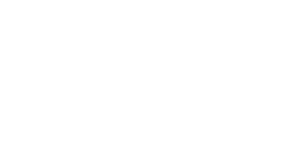

In [62]:
%matplotlib notebook

w_plot = 144 # 3 days
fontsize = 13

y_pred = y_pred_list[-3]

y_pred = y_pred.reshape(len(y_pred))

Residual = list(y_test) - y_pred

plt.figure(figsize=(8,3))
plt.plot(np.arange(0, (w_plot)), y_test[-w_plot:], label = 'Real values', linewidth = 1.5, color = 'steelblue')
plt.plot(np.arange(0, (w_plot)), y_pred[-w_plot:], label = 'Predicted values', linewidth = 1.2, color= 'deepskyblue')
plt.plot(np.arange(0, (w_plot)), Residual[-w_plot:], label = 'Residual error', linewidth = 0.8, color = 'slategrey')
plt.fill_between(np.arange(0, (w_plot)),  data['spike_lowerlim'][-w_plot:],data['spike_upperlim'][-w_plot:], facecolor='skyblue', alpha=0.5, label = 'Not spike regions')
plt.xlim(0, w_plot - 1)
plt.ylim(-100, 260)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('Linear Regression predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('LSTM_2_hidden_100_nerons.png')

In [60]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (96, 96, 200)             172000    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (96, 96, 200)             0         
_________________________________________________________________
dropout_40 (Dropout)         (96, 96, 200)             0         
_________________________________________________________________
lstm_41 (LSTM)               (96, 200)                 320800    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (96, 200)                 0         
_________________________________________________________________
dropout_41 (Dropout)         (96, 200)                 0         
_________________________________________________________________
dense_25 (Dense)             (96, 1)                 